### Testing

In [260]:
import os
import numpy as np
from PIL import Image, ImageOps
import nibabel as nib
import matplotlib.pyplot as plt
import os
import random
import numpy as np


In [261]:
IMAGE_SIZE = 128
IMAGE_CHANNELS = 3
NII_ROOT = './data/models/CRL_FetalBrainAtlas_2017v3/'
USG_IMAGES = "./data/usg"
MRI_IMAGES="./data/models/images"

In [262]:
def save_nii_too_image(root_path: str, images_destination, images_per_file=1) -> None:
    checked_files = []
    for filename in os.listdir(root_path):
        if (not filename.__contains__("nii.gz")):
            continue
        try:
            file_path = os.path.join(root_path, filename)
            nifti_img = nib.load(file_path)
            nii_data = nifti_img.get_fdata()
            slices = []
            weights = []
            for slice_Number in range(nii_data.shape[2]):
                slice_raw = nii_data[:, :, slice_Number]
                if (sum(sum(slice_raw)) > 0):  # Take pictures that contians brain content
                    slices.append(slice_raw)
                    weights.append(sum(sum(slice_raw)))
            max_weight = max(weights)
            weights = [weight/max_weight for weight in weights]
            drafts = random.choices(slices, weights=weights, k=images_per_file)
            for i, x in enumerate(drafts):
                im = Image.fromarray(x.astype(np.uint8)).convert('RGB')
                im = im.resize((IMAGE_SIZE,IMAGE_SIZE))
                #im = ImageOps.gra(im)
                im.save(images_destination+f'/{filename}_{i}.jpeg')
        except Exception as ex:
            raise ex

    print(checked_files)


save_nii_too_image(NII_ROOT, "./data/models/images", 1)


[]


In [263]:
def prepeare_data(images_path:str, output_numpy_loc: str | None)->np.ndarray:
    data = []
    for filename in os.listdir(images_path):
        path = os.path.join(images_path, filename)
        image = Image.open(path).resize((IMAGE_SIZE, IMAGE_SIZE), Image.LANCZOS)
        # plt.imshow(image)
        # plt.show()
        data.append(np.asarray(image))
        
    data = np.reshape(
        data, (-1, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))
    
    #data = data / 127.5 - 1
    
    if output_numpy_loc:
        np.save(output_numpy_loc, data)
    return data

In [264]:
from keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
import numpy as np
from keras.applications import ResNet50


In [265]:
# Preview image Frame
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 4
SAVE_FREQ = 100  # Size vector to generate images from
NOISE_SIZE = 100
# Configuration
EPOCHS = 50  # number of iterations
BATCH_SIZE = 16
GENERATE_RES = 3
IMAGE_SIZE = 128  # rows/colsIMAGE_CHANNELS = 3


In [266]:

def build_discriminator(image_shape):    
    big_model = ResNet50(include_top=False,
                          weights='imagenet',
                          input_shape=(128,128,3))
    big_model.trainable = False
    X = big_model.output
    X = Flatten()(X)

    X = Dense(512, activation='relu', kernel_initializer='he_uniform')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Dense(256, activation='relu', kernel_initializer='he_uniform')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    output = Dense(1, activation='softmax')(X)
    model = Model(inputs=big_model.input, outputs=output)
    return model


build_discriminator((IMAGE_SIZE,IMAGE_SIZE,3))

In [267]:
from keras.layers import Add
def build_generator(image_size, channels):
    # Input layer
    input = Input(shape=image_size)

    # Downsampling block
    x = Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    # Convolutional block
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)
    # Convolutional block
    

    # Residual blocks
    res_blocks = 12
    for i in range(res_blocks):
        res = x
        x = Conv2D(128, kernel_size=3, padding="same")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)
        x = Conv2D(64, kernel_size=3, padding="same")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Add()([x, res])
        x = Activation("relu")(x)

    # Upsampling block
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)

    # Additional convolutional block
    x = Conv2D(32, kernel_size=3, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)

    # Output layer
    x = Conv2D(channels, kernel_size=3, padding="same")(x)
    output = Activation("tanh")(x)

    # Model
    model = Model(input, output)

    return model

build_generator((IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE),3)


In [268]:
image_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)
optimizer = Adam(1.5e-4, 0.5)

def build_GAN(generator: Model, discriminator: Model, input:Input) -> Model:
    discriminator.compile(loss="binary_crossentropy",
                        optimizer=optimizer, metrics=["accuracy"])
    generator.compile(loss="binary_crossentropy",
                          optimizer=optimizer, metrics=["accuracy"])
    generator_output = generator(input)
    discriminator.trainable = False
    discriminator_output = discriminator(generator_output)
    gan = Model(input, discriminator_output)
    gan.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=["accuracy"])
    return gan


In [269]:
def plot_images_by_epoch(mri_image, usg_image, epoch:int) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    image_clipped = np.clip(usg_image, 0, 1)
    gray_usg = Image.fromarray((image_clipped*255).astype("uint8")).convert('L')
    
    # Plot the second image in the right subplot
    axs[1].imshow(gray_usg, cmap='gray')
    axs[1].set_title(f'Generated USG image ')
    # Plot the first image in the left subplot
    axs[0].imshow(np.clip(mri_image, 0, 1), cmap='gray', vmin=0, vmax=255)
    axs[0].set_title('MRI Image')
    # Add a title to the whole figure
    fig.suptitle(f'MRI -> USG image transformation, epoch: {epoch}')
    plt.show()


In [ ]:
def train(generator:Model, discriminator:Model, epochs: int, mri_images, usg_images ) -> tuple[Model,np.ndarray,np.ndarray]:
    y_real = np.ones((BATCH_SIZE, 1))
    y_fake = np.zeros((BATCH_SIZE, 1))
    gan = build_GAN(
        generator=generator,
        discriminator=discriminator,
        input=Input(shape=(IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))
        )
    for epoch in range(epochs):
        idx = np.random.randint(0, mri_images.shape[0], BATCH_SIZE)
        x_real = usg_images[idx]
        generator_input = mri_images[idx]
        x_fake = generator.predict(generator_input)
        if epoch%5 == 0:
            plot_images_by_epoch(mri_images.copy()[idx][0],x_fake.copy()[0],epoch)
        discriminator.trainable=True
        discriminator_metric_real = discriminator.train_on_batch(x_real, y_real)
        discriminator_metric_generated = discriminator.train_on_batch(x_fake, y_fake)
        discriminator.trainable = False
        discriminator_metric = 0.5 * np.add(discriminator_metric_real, discriminator_metric_generated)
        generator_metric = gan.train_on_batch(generator_input, y_real)
        print(f"{epoch} epoch, Discriminator loss: {discriminator_metric[0]}, accuracy: {discriminator_metric[1]}, Generator loss: {generator_metric[0]} accuracy: {generator_metric[1]}")
    return gan , discriminator_metric, generator_metric

In [271]:
usg_images = prepeare_data(USG_IMAGES,"usg_images.npy")
mri_images = prepeare_data(MRI_IMAGES,"mri_images.npy")
print("Usg images:", usg_images.shape)
print("Mri images:", mri_images.shape)

OSError: [Errno 22] Invalid argument: 'mri_images.npy'

1/1 [==============================] - 3s 3s/step


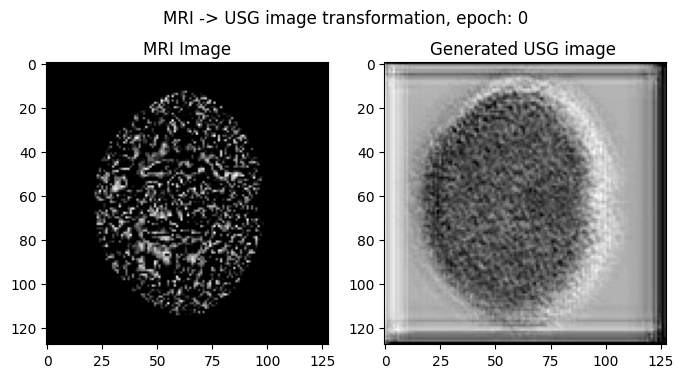

0 epoch, Discriminator loss: 0.870741069316864, accuracy: 0.5, Generator loss: 1.0979948043823242 accuracy: 1.0
1/1 [==============================] - 3s 3s/step
1 epoch, Discriminator loss: 0.970391035079956, accuracy: 0.5, Generator loss: 1.4572694301605225 accuracy: 1.0
1/1 [==============================] - 3s 3s/step
2 epoch, Discriminator loss: 0.9165228009223938, accuracy: 0.5, Generator loss: 1.1715973615646362 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
3 epoch, Discriminator loss: 0.6511639505624771, accuracy: 0.5, Generator loss: 0.854957103729248 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
4 epoch, Discriminator loss: 0.6457405984401703, accuracy: 0.5, Generator loss: 0.8170570135116577 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
5 epoch, Discriminator loss: 0.5095692723989487, accuracy: 0.5, Generator loss: 0.929137110710144 accuracy: 1.0
1/1 [==============================] - 2s 2s/step
6 epoch, Discriminator los

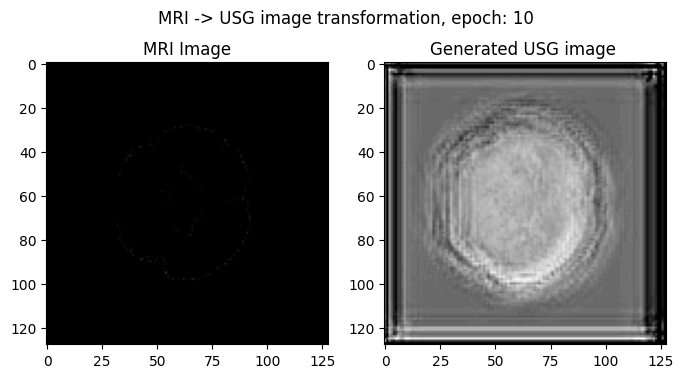

KeyboardInterrupt: 

In [ ]:
image_size = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)
gnerator = build_generator(image_size, IMAGE_CHANNELS)
discriminator = build_discriminator(image_size)
model , discriminator_metrics, generator_metrics = train(
    generator=gnerator,
    discriminator=discriminator,
    epochs = 50,
    mri_images=mri_images[:50],
    usg_images=usg_images[:50]
)

In [ ]:
def test_discriminator(discriminator:Model, usg_images, mri_images)->None:
    dict = {1: 0, 0: 0}
    for x in usg_images:
        input_data = np.expand_dims(x, axis=0)
        y = discriminator.predict(input_data,verbose=0)
        dict[round(y[0][0])] = dict[round(y[0][0])]+1
        
    for x in mri_images:
        input_data = np.expand_dims(x, axis=0)
        y = discriminator.predict(input_data, verbose=0)
        dict[round(y[0][0])] = dict[round(y[0][0])]+1
    print(dict)
test_discriminator(discriminator,usg_images,mri_images)

{1: 253, 0: 0}


In [ ]:
def plot_generator_image(image)->None:
    input_data = np.expand_dims(image, axis=0)
    img = gnerator(input_data).numpy()[0]
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    image_clipped = np.clip(img, 0, 1)
    gray_usg = Image.fromarray((image_clipped*255).astype("uint8")).convert('L')
    # Plot the second image in the right subplot
    axs[1].imshow(gray_usg, cmap='gray')
    axs[1].set_title('Generated USG image')
    # Plot the first image in the left subplot
    axs[0].imshow(np.clip(image, 0, 1) , cmap='gray', vmin=0, vmax=255)
    axs[0].set_title('MRI Image')
    # Add a title to the whole figure
    fig.suptitle('MRI -> USg image transformation')
    plt.show()

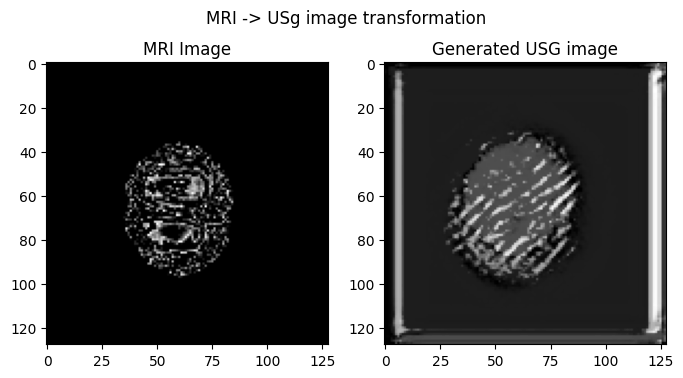

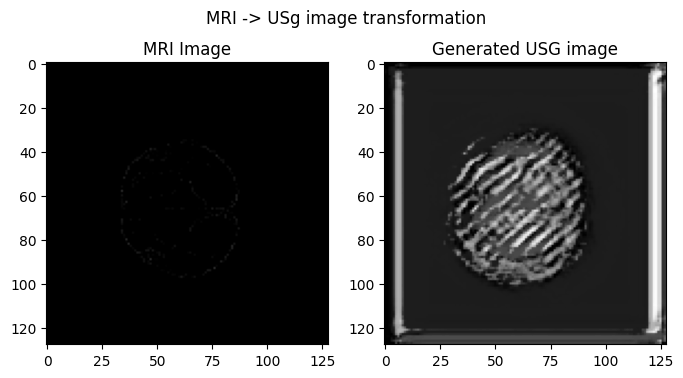

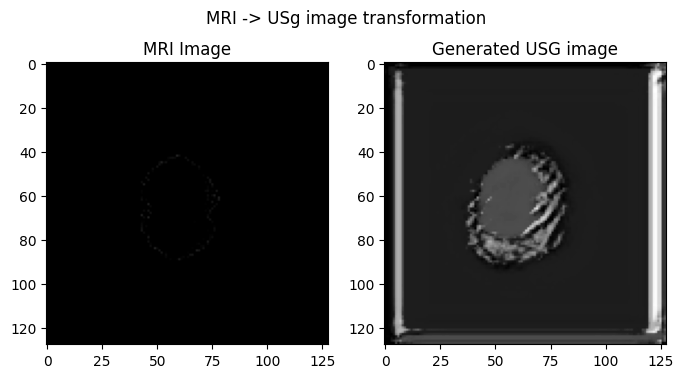

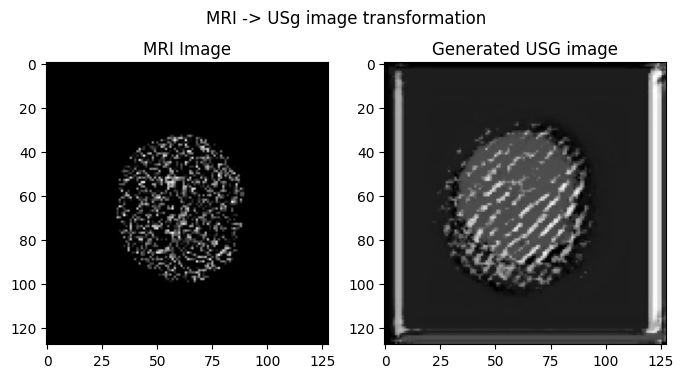

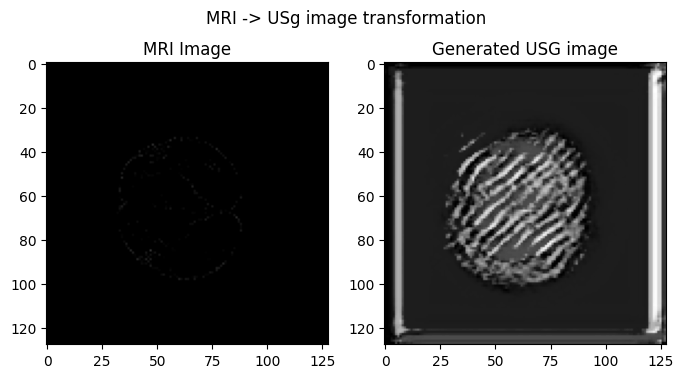

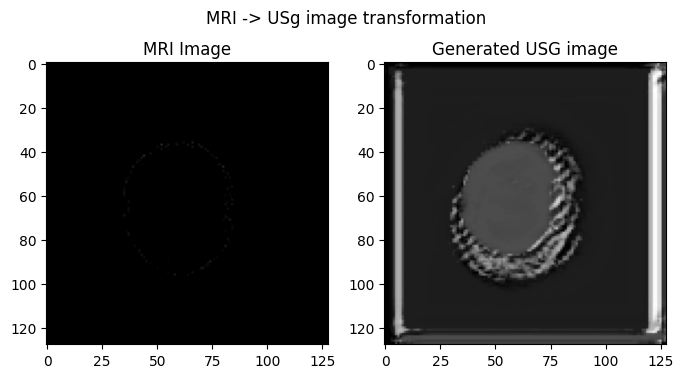

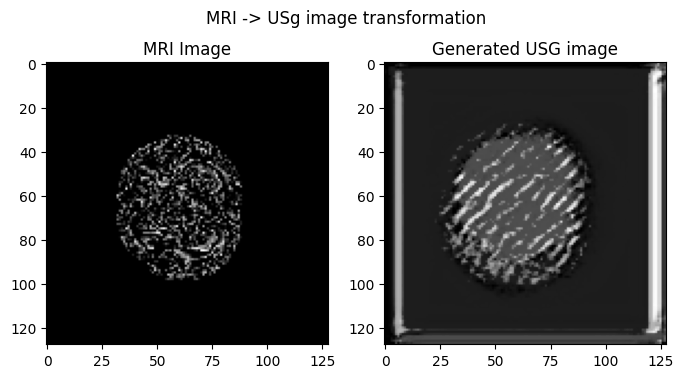

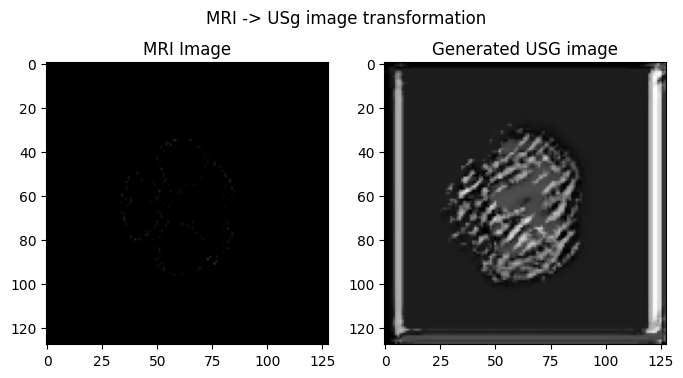

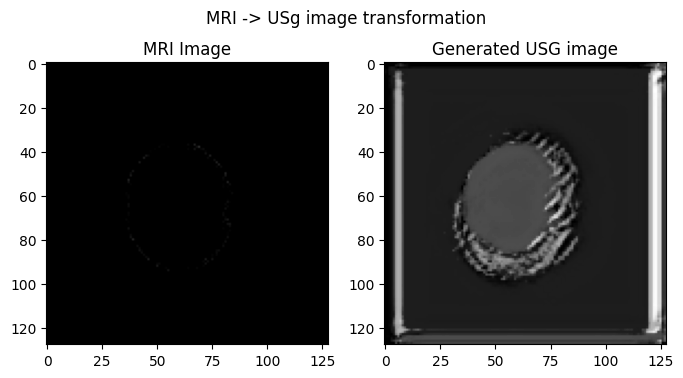

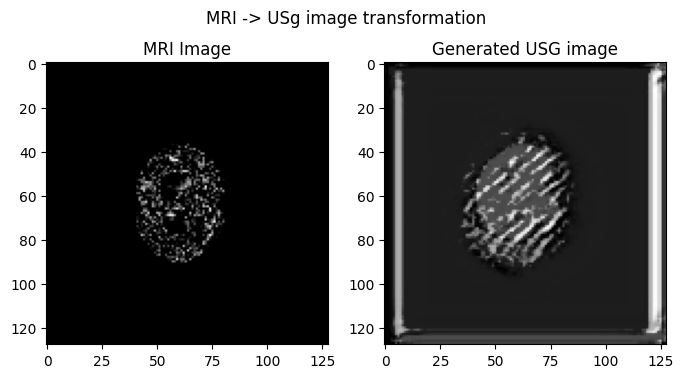

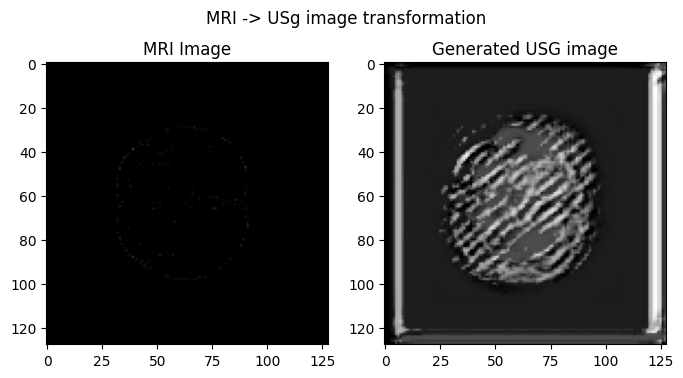

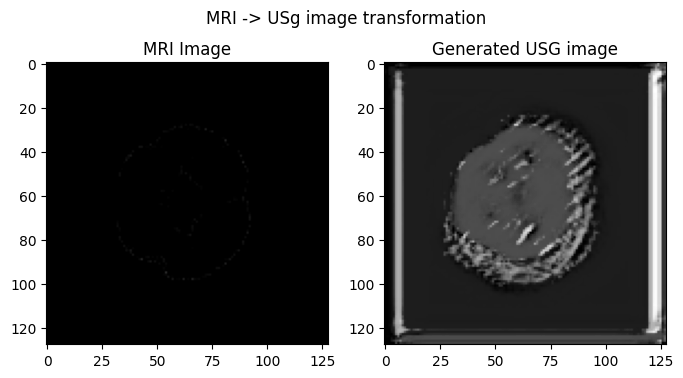

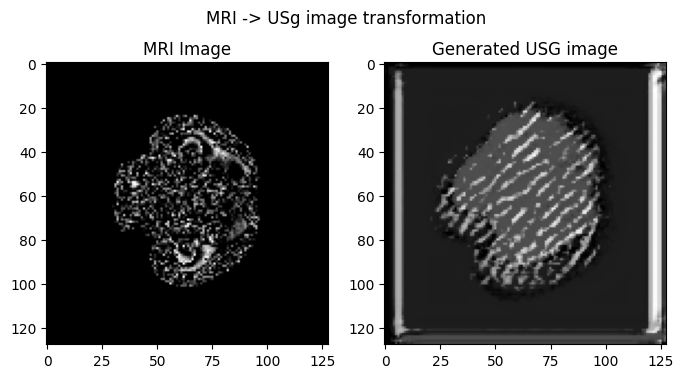

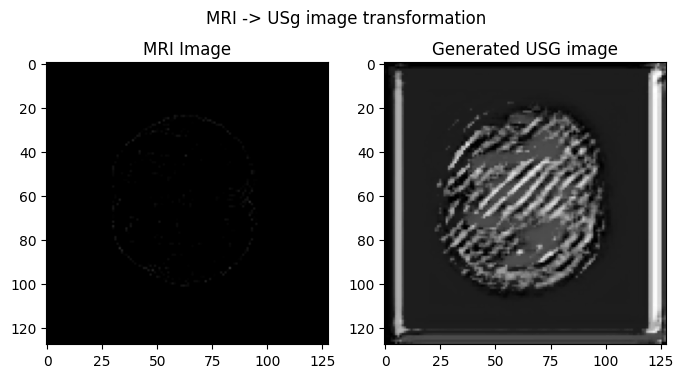

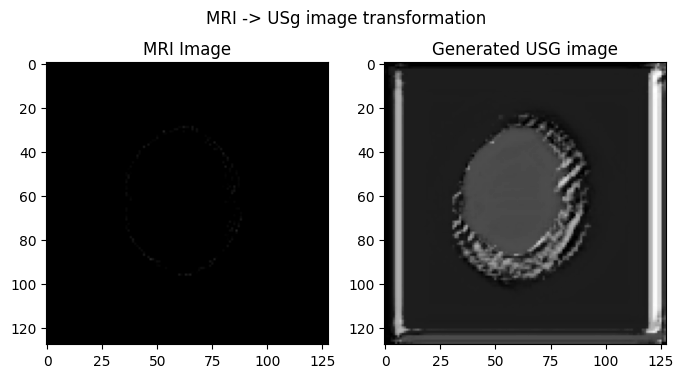

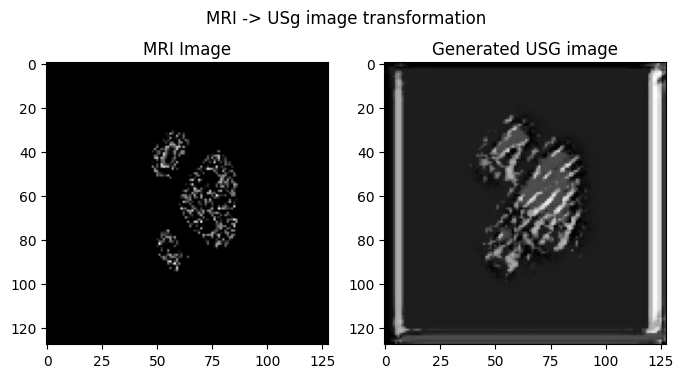

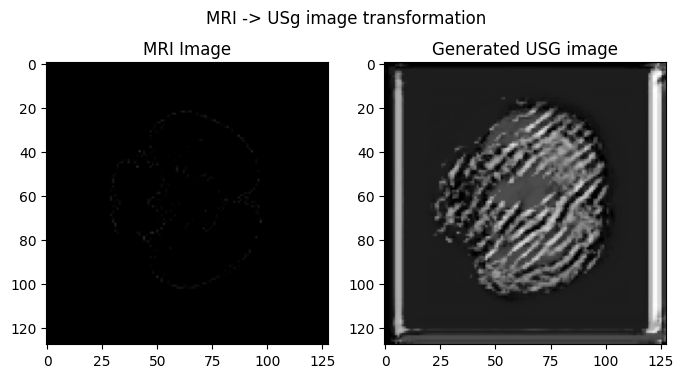

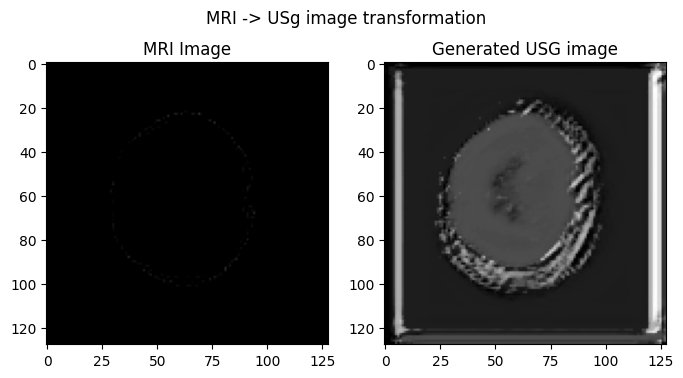

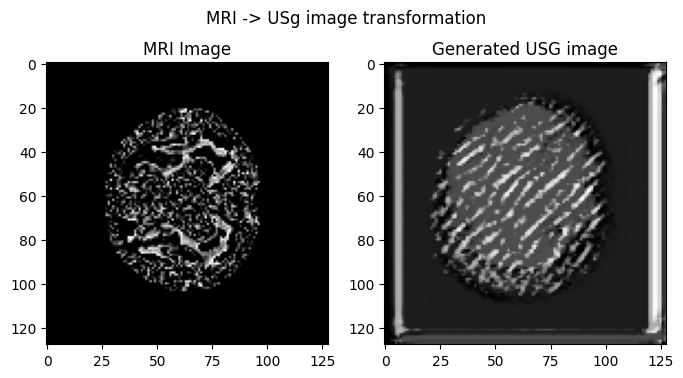

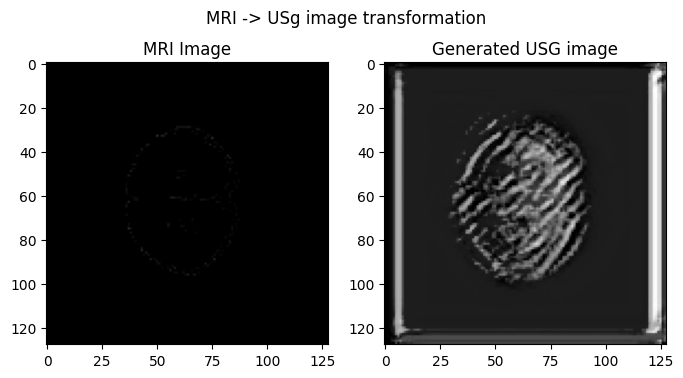

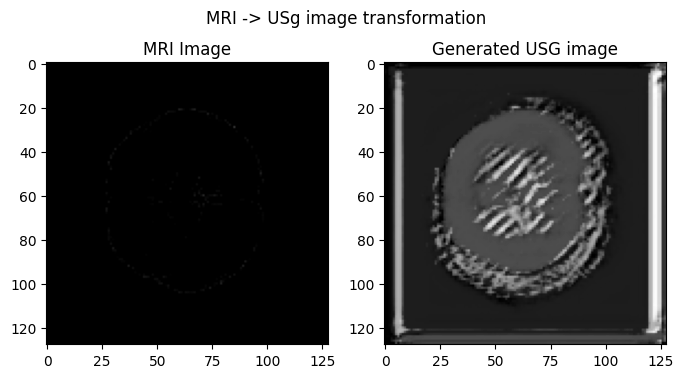

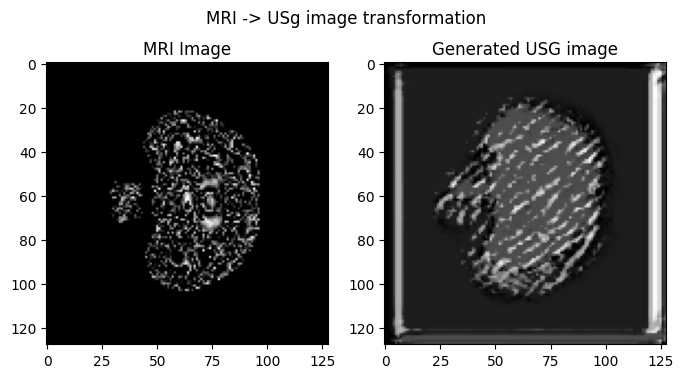

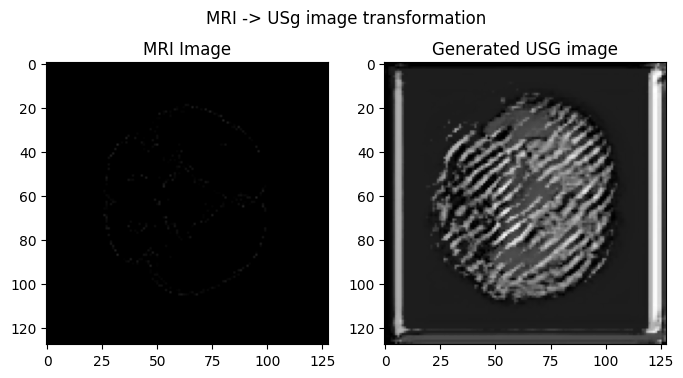

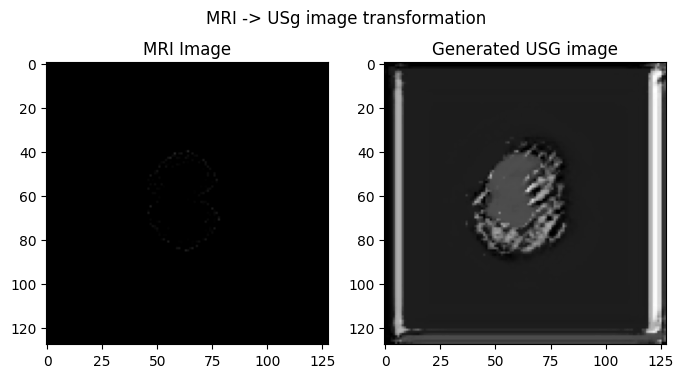

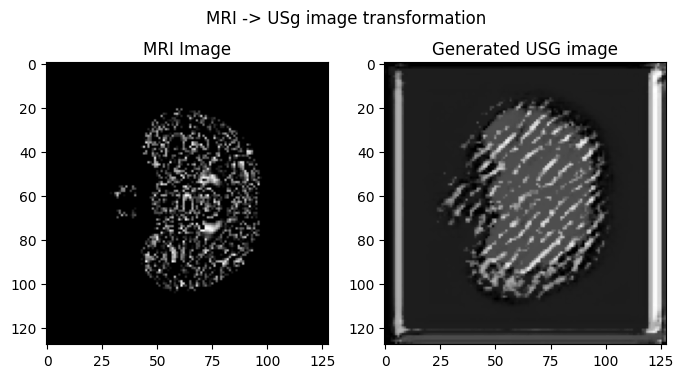

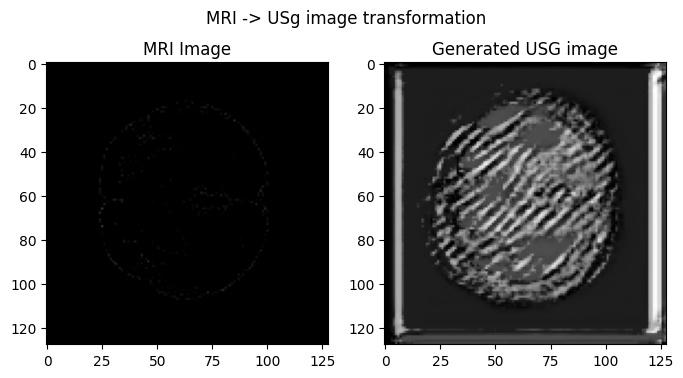

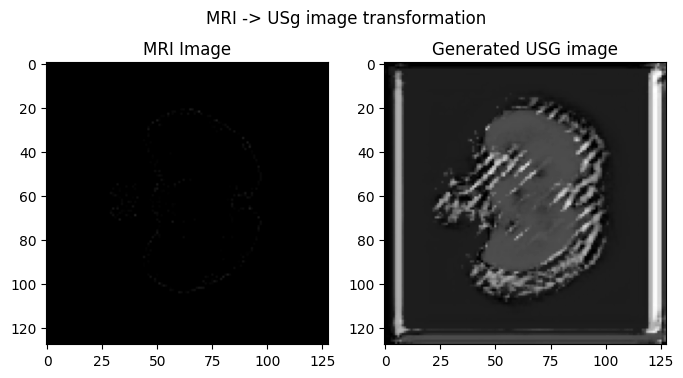

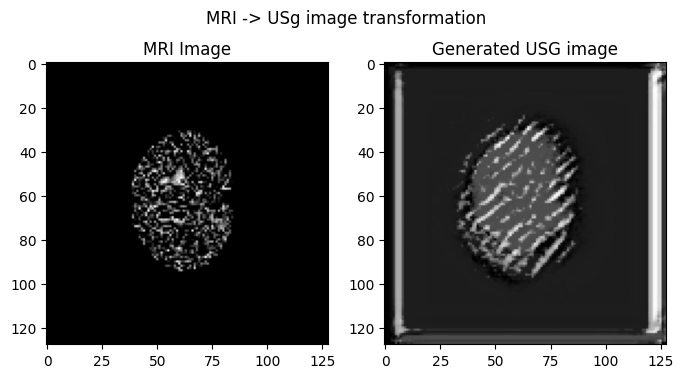

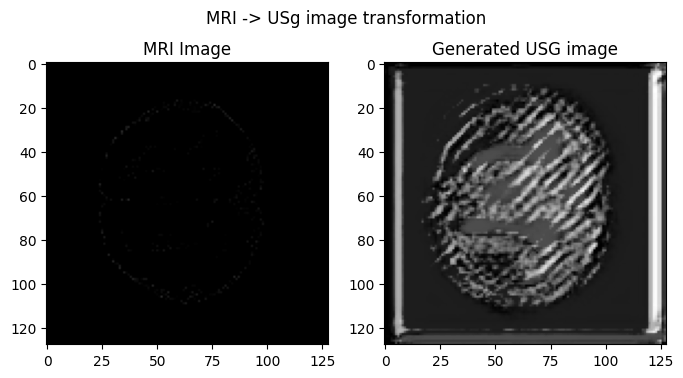

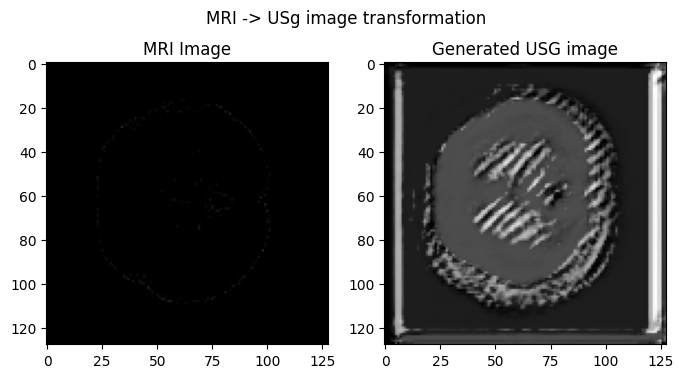

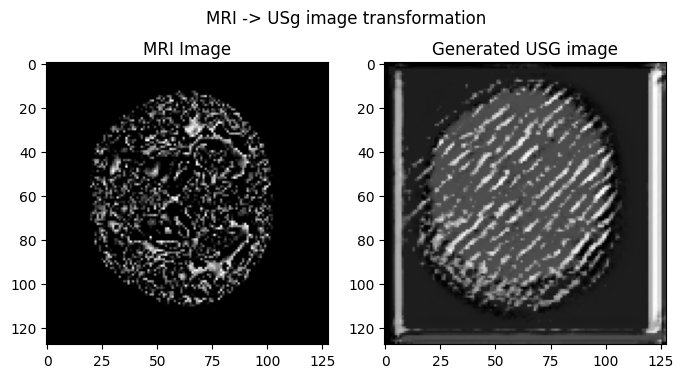

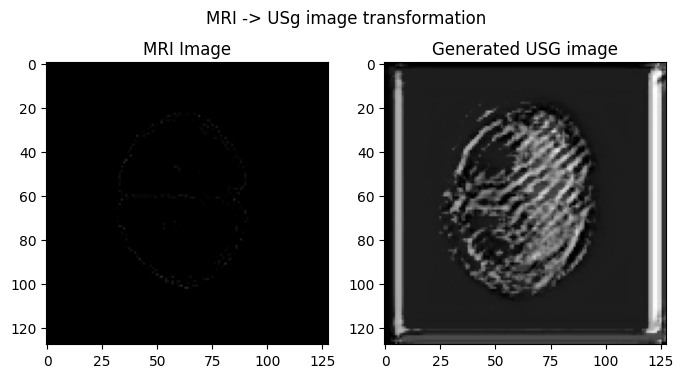

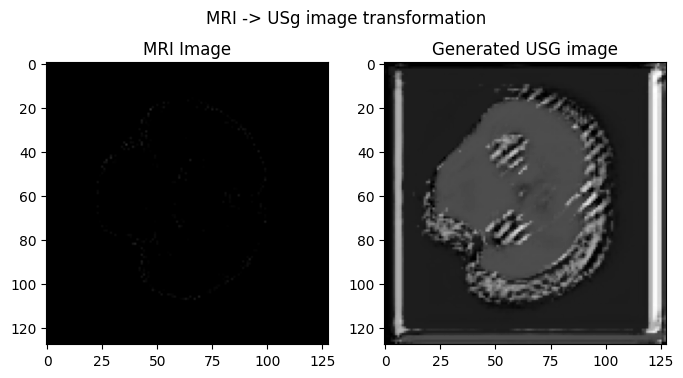

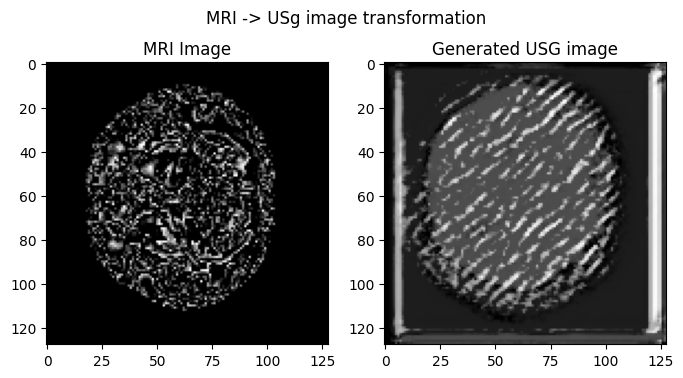

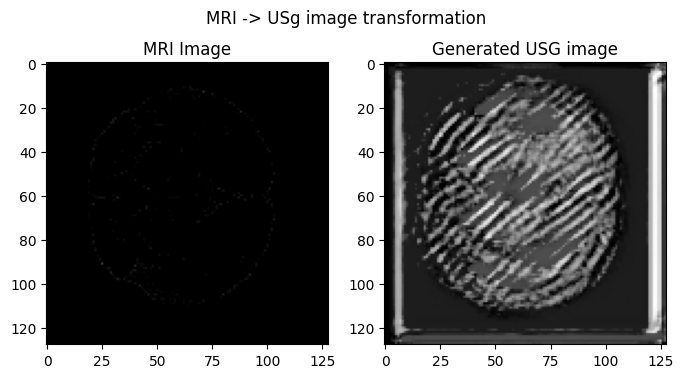

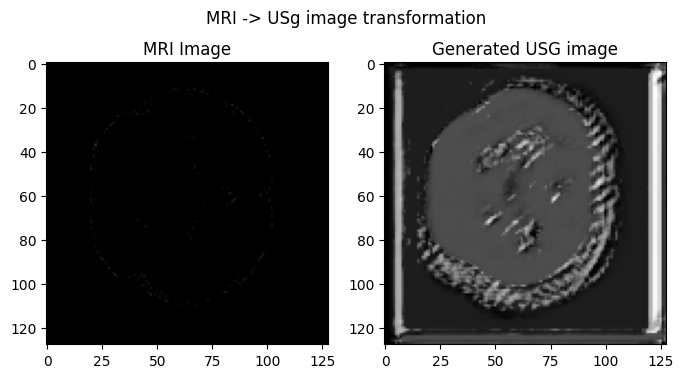

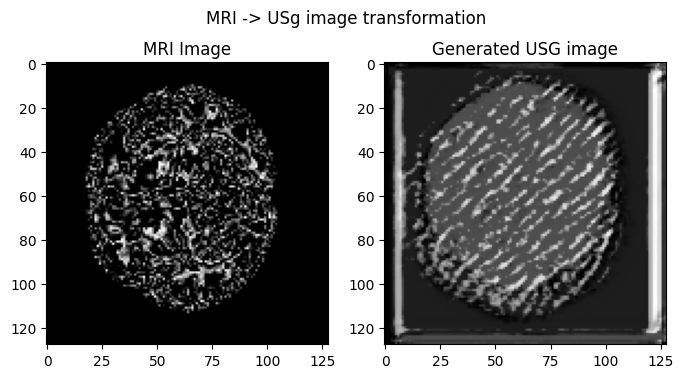

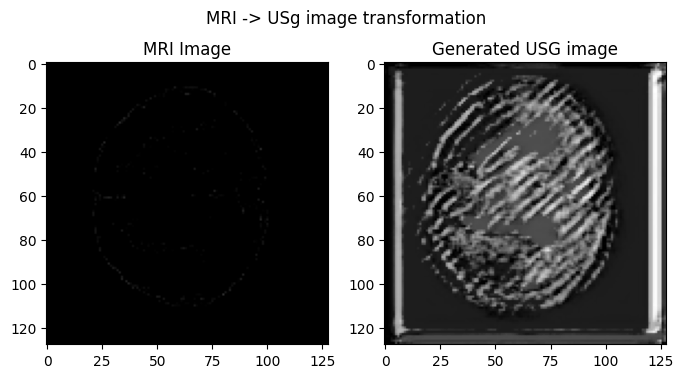

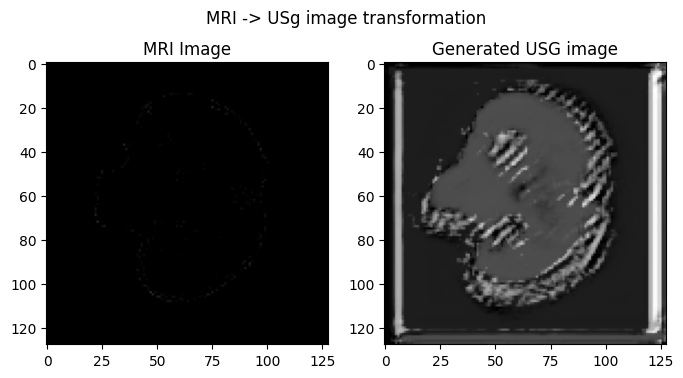

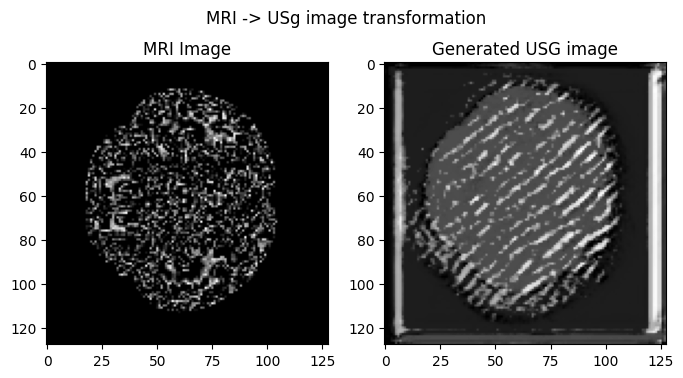

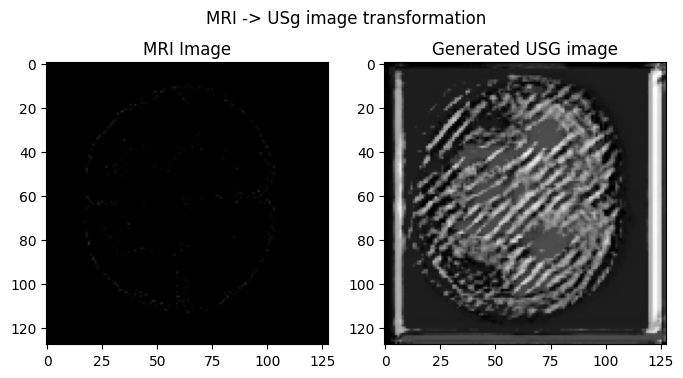

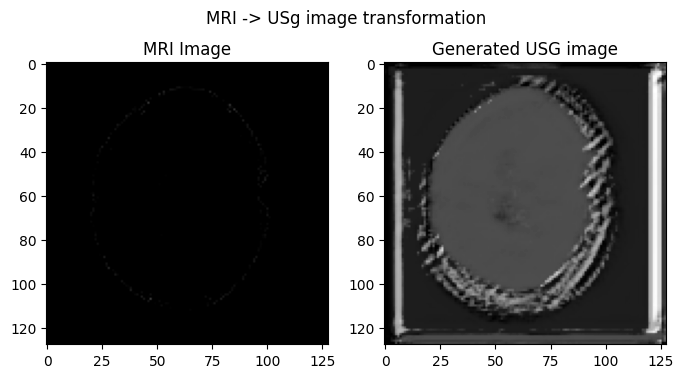

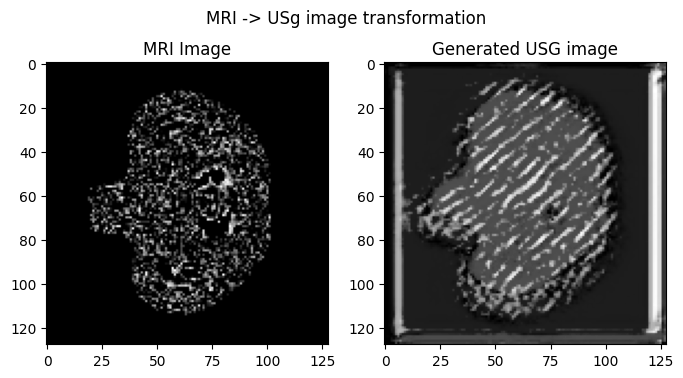

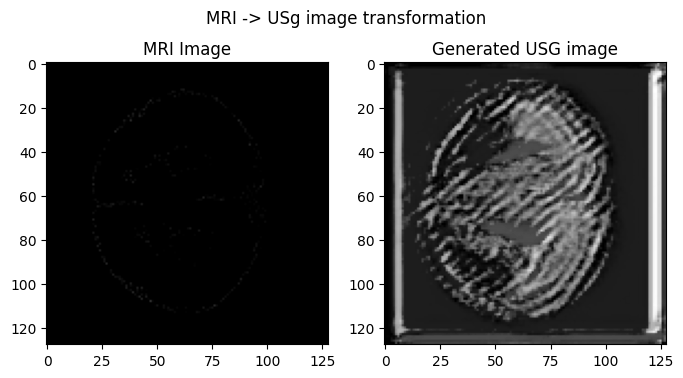

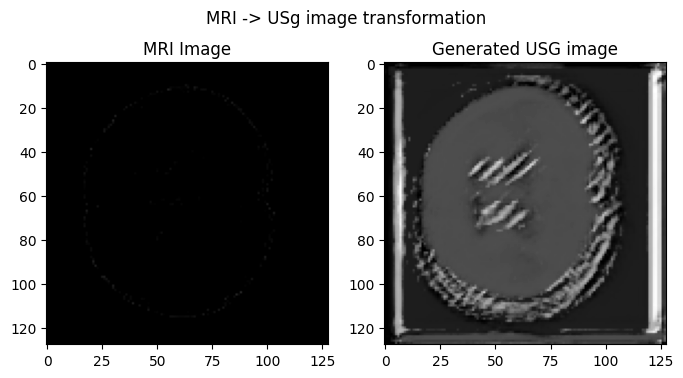

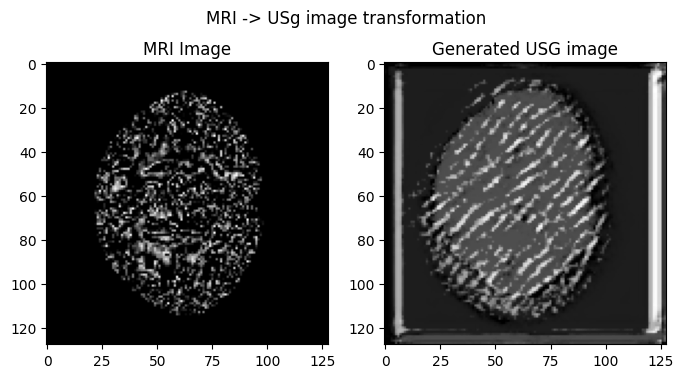

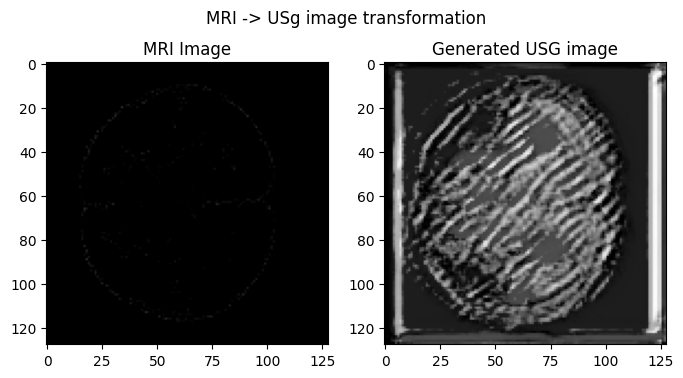

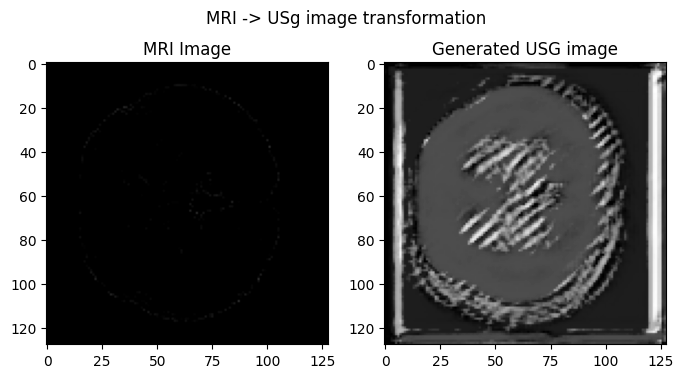

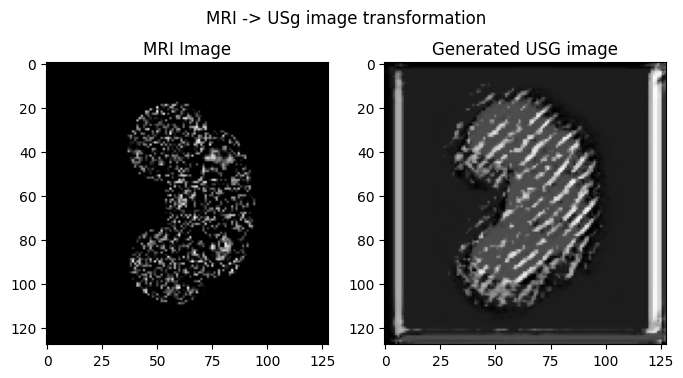

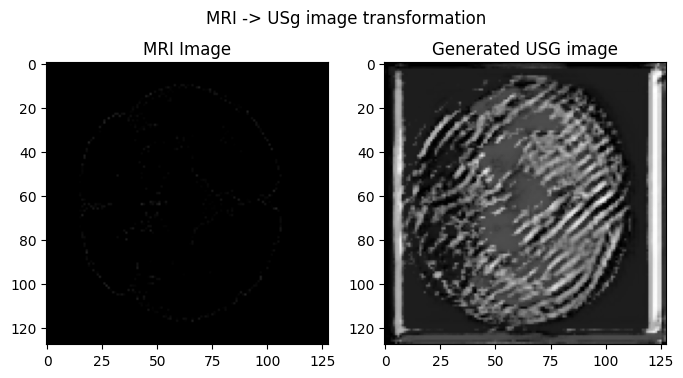

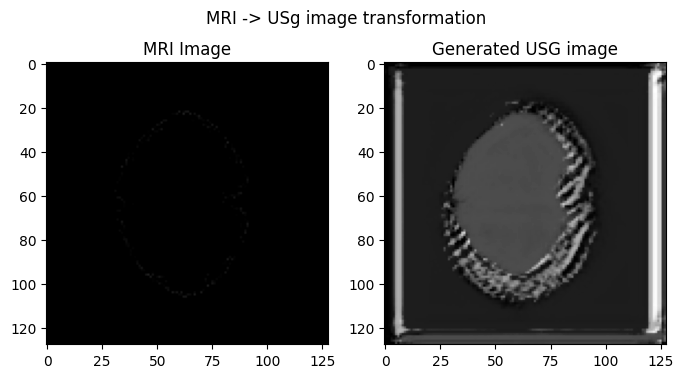

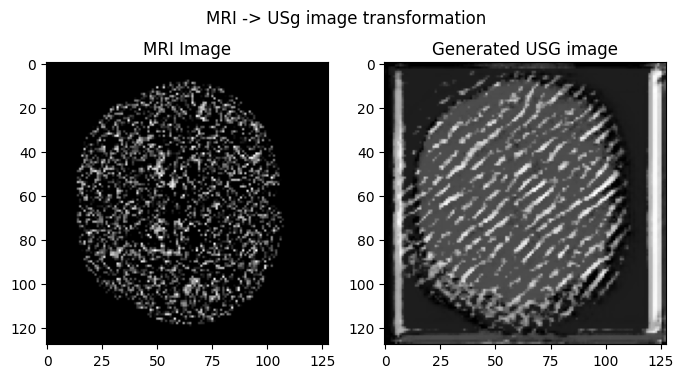

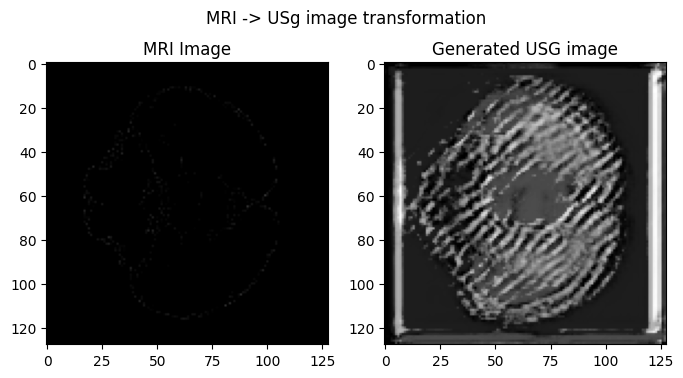

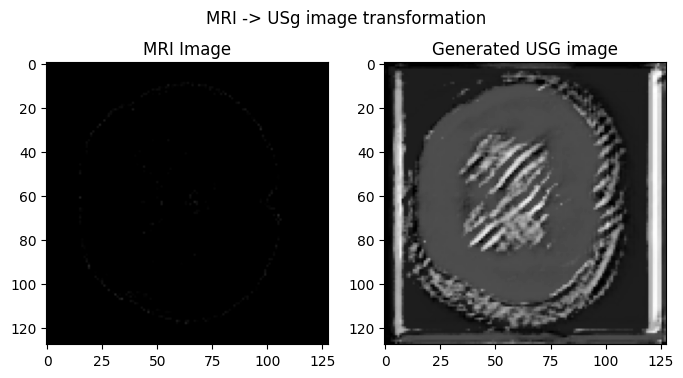

In [ ]:
for i in range(0,len(mri_images)):
    plot_generator_image(mri_images[i]) 

